In [1]:

%pprint

Pretty printing has been turned OFF



# Data Scientist Technical Interview Challenge
----


## Problem Statement Summary
Your task is to build a classifier that can determine what the user is doing with their wrist during each whole body movement.
- Determine how many different wrist-motion classes there are, and (if possible) use features to identify what motion each class is representing.
- Produce quantitative estimates of the generalization performance of your classifier.
- Provide a brief (1-2 page report) describing your process, methods, and results.
- Please perform this exercise in Python, and produce clean, readable code that could be readily used by other engineers in a cloud-based (i.e., notebook server) environment.
- Be sure to publish your code to a public GitHub repository and link this repository in your report.

Have fun!


## Import packages and function definition

In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

# Get an instance of the storage calss
from storage import Storage
s = Storage()


## Data Exploration

Much of the time spent on this task is going to be spent getting familiar with the data, learning as much as possible from its structure and searching for transformations that might expose measurable differences between wrist motions that would aid in classification. This section of the report will describe some of that process.

In [4]:

import pandas as pd
import os

csv_path = os.path.join(s.data_csv_folder, 'pison_data_interview.csv')
pison_df = pd.read_csv(os.path.abspath(csv_path), encoding=s.encoding_type, header=None)


## Data Formats
A csv file attached to the email contains Pison device data. Each row is a sample. The
columns are as follows:
- timestamp (milliseconds with microsecond precision);
- channel 0 raw, channel 1 raw, channel 0 high-passed, and channel 1 high-passed (all in ADC counts);
- quaternion x, y, z, and w;
- gyroscope x, y, and z in degrees per second;
- accelerometer x, y, and z in meters per second squared;
- body movement label;
- and finally, repetition number (where there is one "repetition" for a given prompting window).

The body movement coding is:
- 0 = standing #1, 
- 1 = standing #2, 
- 2 = walking, 
- 3 = walking fast, 
- 4 = running.

The accelerometer and gyroscope coordinates follow the ENU convention:
- The X-axis points East.
- The Y-axis points North.
- The Z-axis points Up.

The quaternion coordinates follow the convention:
- The X-axis points West.
- The Y-axis points South.
- The Z-axis points Up.

In [5]:

pison_df.columns = [
    'timestamp_in_milliseconds', 
    'channel_0_raw_in_ADC_counts', 
    'channel_1_raw_in_ADC_counts', 
    'channel_0_high_passed_in_ADC_counts', 
    'channel_1_high_passed_in_ADC_counts', 
    'quaternion_x', 
    'quaternion_y', 
    'quaternion_z', 
    'quaternion_w', 
    'gyroscope_x_in_degrees_per_second', 
    'gyroscope_y_in_degrees_per_second', 
    'gyroscope_z_in_degrees_per_second', 
    'accelerometer_x_in_meters_per_second_squared', 
    'accelerometer_y_in_meters_per_second_squared', 
    'accelerometer_z_in_meters_per_second_squared', 
    'body_movement_label', 
    'prompting_window_repetition_number']
pison_df = pison_df.sort_values('timestamp_in_milliseconds')
pison_df.sample(4).T

,2533,12187,1323,4178
timestamp_in_milliseconds,1.530663e+06,1.601409e+06,1.522903e+06,1.544203e+06
channel_0_raw_in_ADC_counts,1.251712e+07,1.278424e+07,1.259024e+07,1.255950e+07
channel_1_raw_in_ADC_counts,1.259111e+07,1.258425e+07,1.256316e+07,1.255626e+07
channel_0_high_passed_in_ADC_counts,1.844200e+04,5.502500e+04,2.378000e+03,-7.320000e+02
channel_1_high_passed_in_ADC_counts,1.020900e+04,-1.178500e+04,-3.048000e+03,4.980000e+02
quaternion_x,-5.194092e-02,1.959229e-02,-1.463013e-01,2.163696e-01
quaternion_y,6.555786e-01,-4.731445e-01,3.384399e-01,6.884155e-01
quaternion_z,7.510376e-01,-8.746338e-01,8.104858e-01,6.868897e-01
quaternion_w,5.883789e-02,1.041260e-01,4.551392e-01,8.660889e-02
gyroscope_x_in_degrees_per_second,1.107868e+01,9.472828e+01,-4.403494e+01,8.672701e+00



## Feature generation and data wrangling
### Elapsed time

Looking at the timestamps shows a regular pause of 4 seconds that create distict data collection periods because the device is not collecting data.

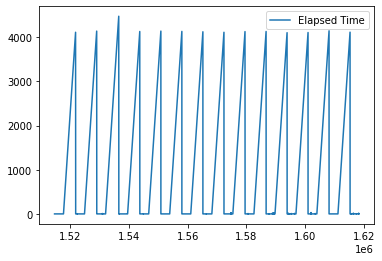

In [6]:

import matplotlib.pyplot as plt

pison_df['elapsed_milliseconds'] = pison_df.timestamp_in_milliseconds.diff()
fig, ax = plt.subplots()
ax.plot(pison_df.timestamp_in_milliseconds, pison_df.elapsed_milliseconds, label='Elapsed Time')
plt.legend();

In [7]:

mask_series = (pison_df.elapsed_milliseconds > 4_000)
spike_series = pison_df[mask_series].timestamp_in_milliseconds
spike_times_list = spike_series.tolist()
mean = spike_series.diff().mean()/1_000
std = spike_series.diff().std()/1_000
print(f'There are {len(spike_times_list)+1} distinct data collection periods, each lasting {mean:0.2} +-{std:0.1} seconds.')

There are 15 distinct data collection periods, each lasting 7.2 +-0.1 seconds.



That happens right at the time of the body movement label (and repetition number) change

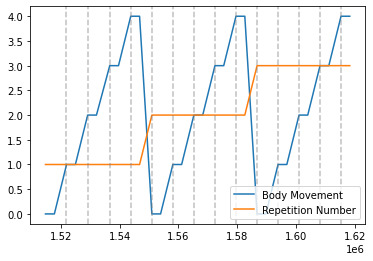

In [8]:

fig, ax = plt.subplots()
ax.plot(pison_df.timestamp_in_milliseconds, pison_df.body_movement_label, label='Body Movement')
ax.plot(pison_df.timestamp_in_milliseconds, pison_df.prompting_window_repetition_number, label='Repetition Number')
plt.legend()
for x in spike_times_list:
    plt.axvline(x=x, alpha=0.5, ls='--', c='gray')


Examining the Body Movement and Repetition Number columns shows that each "window" is given one label for each of these columns. As we progress through the 15 windows, Body Movement cycles in order through its range of 5 values three times. Repetition Number stays constant at 1 through the first five windows (representing the first set of five body movements), 2 for the second five, and 3 for the final five prompting windows. From this **we can infer that there are 5 different wrist-motion classes**, because each class is repeated exactly 3 times in the 15 windows.

Looking between these pauses shows samples collected roughly every 3 milliseconds (+/- 0.06 ms).

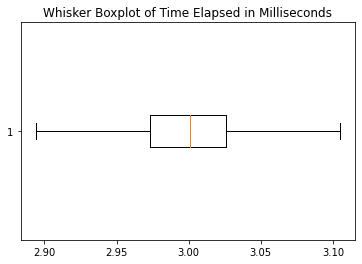

In [9]:

fig, ax = plt.subplots()
ax.set_title('Whisker Boxplot of Time Elapsed in Milliseconds')
whiskers_dict = ax.boxplot(pison_df.elapsed_milliseconds.dropna().values, vert=False, showfliers=False)

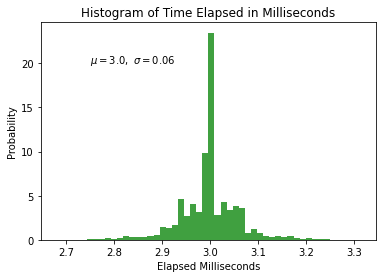

In [10]:

mask_series = (pison_df.elapsed_milliseconds < 4)
n, bins, patches = plt.hist(pison_df[mask_series].elapsed_milliseconds, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Elapsed Milliseconds')
plt.ylabel('Probability')
plt.title('Histogram of Time Elapsed in Milliseconds')
mean = pison_df.elapsed_milliseconds[mask_series].mean()
std = pison_df.elapsed_milliseconds[mask_series].std()
text_obj = plt.text(2.75, 20, rf'$\mu={mean:0.2}, \ \sigma={std:0.2}$')


## Determine how many different wrist-motion classes there are, and (if possible) use features to identify what motion each class is representing.

Let's see if we can visualize the inferred wrist-motion classes in a scatter plot.

In [11]:

from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

columns_list = [
    'channel_0_raw_in_ADC_counts',
    'channel_1_raw_in_ADC_counts',
    'channel_0_high_passed_in_ADC_counts',
    'channel_1_high_passed_in_ADC_counts',
    'quaternion_x',
    'quaternion_y',
    'quaternion_z',
    'quaternion_w',
    'gyroscope_x_in_degrees_per_second',
    'gyroscope_y_in_degrees_per_second',
    'gyroscope_z_in_degrees_per_second',
    'accelerometer_x_in_meters_per_second_squared',
    'accelerometer_y_in_meters_per_second_squared',
    'accelerometer_z_in_meters_per_second_squared']
X1 = pison_df[columns_list].fillna(0).values
scaler = StandardScaler().fit(X1)
X1_scaled = scaler.transform(X1)

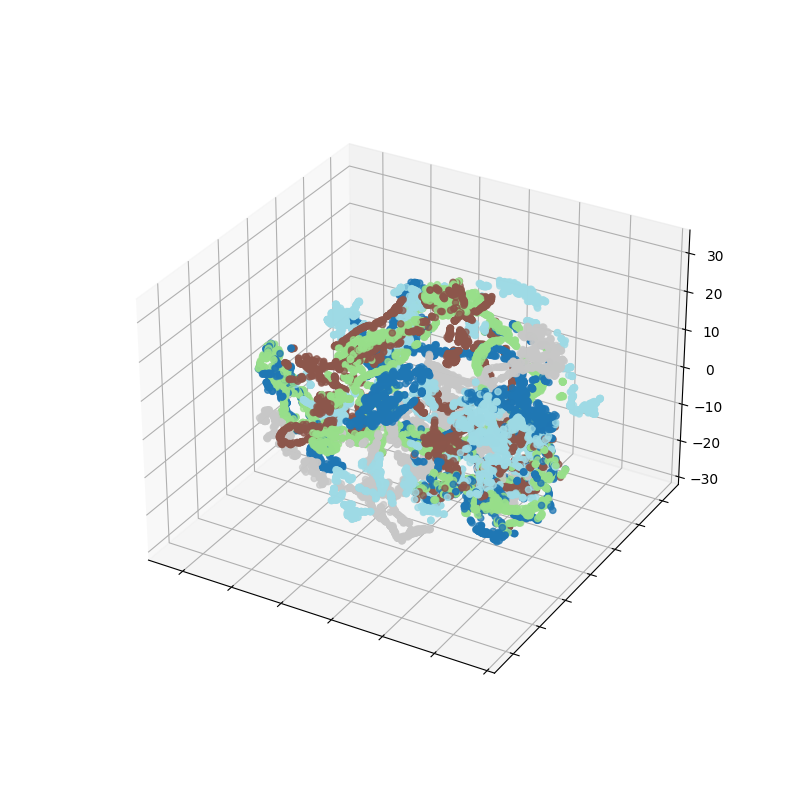

In [12]:

%matplotlib widget

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
tsne_obj = manifold.TSNE(n_components=3, init='pca', random_state=0)
y1 = tsne_obj.fit_transform(X1_scaled)
ax.scatter3D(y1[:, 0], y1[:, 1], y1[:, 2], c=pison_df.body_movement_label.tolist(), cmap=plt.cm.tab20, alpha=0.75)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight');

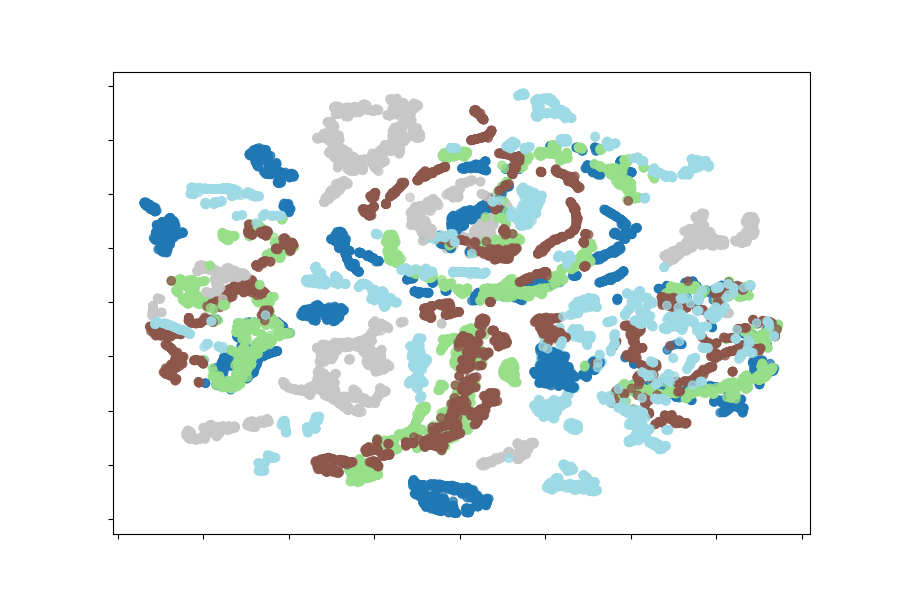

In [13]:

fig, ax = plt.subplots(figsize=(9, 6))
tsne_obj = manifold.TSNE(n_components=2, init='pca', random_state=0)
y1 = tsne_obj.fit_transform(X1_scaled)
ax.scatter(y1[:, 0], y1[:, 1], c=pison_df.body_movement_label.tolist(), cmap=plt.cm.tab20, alpha=0.75)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight');


### Split the Dataset into Prompting Windows

It looks like the 4 second pause happens at the beginning of all but the first prompt.

In [14]:

columns_list = [
    'timestamp_in_milliseconds',
    'elapsed_milliseconds',
    'body_movement_label',
    'prompting_window_repetition_number']
df = pison_df[columns_list].groupby(['prompting_window_repetition_number', 'body_movement_label']).max()
nonpause_min = df.min().elapsed_milliseconds
mask_series = (pison_df.elapsed_milliseconds > nonpause_min)
PAUSE_MIN = pison_df[mask_series][columns_list].groupby(['prompting_window_repetition_number',
                                                         'body_movement_label']).max().min().elapsed_milliseconds
df

timestamp_in_milliseconds  \
prompting_window_repetition_number body_movement_label                              
1                                  0                                  1517862.337   
                                   1                                  1525002.006   
                                   2                                  1532158.647   
                                   3                                  1539639.645   
                                   4                                  1546797.462   
2                                  0                                  1553931.247   
                                   1                                  1561081.010   
                                   2                                  1568244.044   
                                   3                                  1575374.943   
                                   4                                  1582535.312   
3                                  0                                  1589686.981   
                                   1                                  1596805.545   
                                   2                                  1603901.337   
                                   3                                  1611061.127   
                                   4                                  1618179.410   

                                                        elapsed_milliseconds  
prompting_window_repetition_number body_movement_label                        
1                                  0                                   3.227  
                                   1                                4108.316  
                                   2                                4134.550  
                                   3                                4470.426  
                                   4                                4125.823  
2                                  0                                4134.915  
                                   1                                4127.747  
                                   2                                4119.568  
                                   3                                4108.182  
                                   4                                4123.150  
3                                  0                                4125.870  
                                   1                                4098.926  
                                   2                                4102.602  
                                   3                                4140.652  
                                   4                                4110.498

In [15]:

WINDOW_DFS_LIST = []
def f(df):
    mask_series = (df.elapsed_milliseconds < PAUSE_MIN)
    
    WINDOW_DFS_LIST.append(df[mask_series])
pison_df.groupby(['prompting_window_repetition_number', 'body_movement_label']).apply(f)

# Label the samples by what window they are in
for i, window_df in enumerate(WINDOW_DFS_LIST):
    mask_series = pison_df.index.isin(window_df.index)
    pison_df.loc[mask_series, 'window_label'] = i

len(WINDOW_DFS_LIST)

15

In [16]:

import numpy as np

TIMESTAMP_IN_MILLISECONDS_COLUMN = 0 
CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN = 1 
CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN = 2 
CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN = 3 
CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN = 4 
QUATERNION_X_COLUMN = 5 
QUATERNION_Y_COLUMN = 6 
QUATERNION_Z_COLUMN = 7 
QUATERNION_W_COLUMN = 8 
GYROSCOPE_X_IN_DEGREES_PER_SECOND_COLUMN = 9 
GYROSCOPE_Y_IN_DEGREES_PER_SECOND_COLUMN = 10 
GYROSCOPE_Z_IN_DEGREES_PER_SECOND_COLUMN = 11 
ACCELEROMETER_X_IN_METERS_PER_SECOND_SQUARED_COLUMN = 12 
ACCELEROMETER_Y_IN_METERS_PER_SECOND_SQUARED_COLUMN = 13 
ACCELEROMETER_Z_IN_METERS_PER_SECOND_SQUARED_COLUMN = 14 
BODY_MOVEMENT_LABEL_COLUMN = 15 
PROMPTING_WINDOW_REPETITION_NUMBER_COLUMN = 16

In [17]:

def quat_multiply(q1, q2):
    """ Quaternion multiplication using [x, y, z, w] format """
    
    x = q1[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN] * q2[TIMESTAMP_IN_MILLISECONDS_COLUMN]
    x += q1[TIMESTAMP_IN_MILLISECONDS_COLUMN] * q2[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN]
    x += q1[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]
    x -= q1[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
    
    y = q1[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
    y -= q1[TIMESTAMP_IN_MILLISECONDS_COLUMN] * q2[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]
    y += q1[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN]
    y += q1[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN] * q2[TIMESTAMP_IN_MILLISECONDS_COLUMN]
    
    z = q1[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]
    z += q1[TIMESTAMP_IN_MILLISECONDS_COLUMN] * q2[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
    z -= q1[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] * q2[TIMESTAMP_IN_MILLISECONDS_COLUMN]
    z += q1[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN]
    
    w = q1[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN]
    w -= q1[TIMESTAMP_IN_MILLISECONDS_COLUMN] * q2[TIMESTAMP_IN_MILLISECONDS_COLUMN]
    w -= q1[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
    w -= q1[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN] * q2[CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]
    
    q3 = np.array([x, y, z, w])
    
    return q3

In [18]:

def get_acceleration_velocity_position(window_df):
    """
    Returns a seven element list, the first element of which contains
    acceleration data rotated into the ENU reference frame in the first three columns;
    the final six elements are XYZ velocity and XYZ position in that order.
    """
    
    X_v = np.zeros(len(window_df))
    Y_v = np.zeros(len(window_df))
    Z_v = np.zeros(len(window_df))

    X_p = np.zeros(len(window_df))
    Y_p = np.zeros(len(window_df))
    Z_p = np.zeros(len(window_df))

    acc_ref = np.zeros((len(window_df), 4))
    t_diff = np.diff(window_df.timestamp_in_milliseconds.values)/1000
    for ii in range(1, len(window_df)):
        acc_temp = quat_multiply(
            np.array([
                window_df.iloc[ii].quaternion_x.squeeze(),
                window_df.iloc[ii].quaternion_y.squeeze(),
                window_df.iloc[ii].quaternion_z.squeeze(),
                window_df.iloc[ii].quaternion_w.squeeze()
            ]), 
            np.array([
                window_df.iloc[ii].accelerometer_x_in_meters_per_second_squared.squeeze(),
                window_df.iloc[ii].accelerometer_y_in_meters_per_second_squared.squeeze(),
                window_df.iloc[ii].accelerometer_z_in_meters_per_second_squared.squeeze(),
                0
            ])
        )
        acc_ref[ii, :] = quat_multiply(
            acc_temp,
            np.array([
                -window_df.iloc[ii].quaternion_x.squeeze(),
                -window_df.iloc[ii].quaternion_y.squeeze(),
                -window_df.iloc[ii].quaternion_z.squeeze(),
                window_df.iloc[ii].quaternion_w.squeeze()
            ])
        )

        X_v[ii] = X_v[ii-1] + acc_ref[ii, TIMESTAMP_IN_MILLISECONDS_COLUMN] * t_diff[ii-1]
        Y_v[ii] = Y_v[ii-1] + acc_ref[ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] * t_diff[ii-1]
        Z_v[ii] = Z_v[ii-1] + (9.82 + acc_ref[ii, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]) * t_diff[ii-1]
        X_p[ii] = X_p[ii-1] + X_v[ii-1] * t_diff[ii-1]
        Y_p[ii] = Y_p[ii-1] + Y_v[ii-1] * t_diff[ii-1]
        Z_p[ii] = Z_p[ii-1] + Z_v[ii-1] * t_diff[ii-1]
    mask_series = pison_df.index.isin(window_df.index)
    window_label = int(pison_df[mask_series].window_label.mode().squeeze())
    
    return [acc_ref, X_v, Y_v, Z_v, X_p, Y_p, Z_p, window_label]

In [19]:

import matplotlib

navs_list = [get_acceleration_velocity_position(window_df) for window_df in WINDOW_DFS_LIST]
len(navs_list)

15

In [44]:

# Create colors list from the window positions
COLORS_LIST = []
COLORS_DICT = {}
for window_label in [nav[-1] for nav in navs_list]:
    
    # Wrist motion 1
    if window_label in [0, 8, 12]:
        if window_label == 0:
            COLORS_DICT[0] = 'xkcd:pale cyan'
            COLORS_LIST.append(COLORS_DICT[0])
        elif window_label == 8:
            COLORS_DICT[8] = 'xkcd:turquoise blue'
            COLORS_LIST.append(COLORS_DICT[8])
        elif window_label == 12:
            COLORS_DICT[12] = 'xkcd:greenish cyan'
            COLORS_LIST.append(COLORS_DICT[12])
        else:
            COLORS_LIST.append('cyan')
    
    # Wrist motion 2
    elif window_label in [1, 6, 11]:
        if window_label == 1:
            COLORS_DICT[1] = 'xkcd:dark forest green'
            COLORS_LIST.append(COLORS_DICT[1])
        elif window_label == 6:
            COLORS_DICT[6] = 'xkcd:bright green'
            COLORS_LIST.append(COLORS_DICT[6])
        elif window_label == 11:
            COLORS_DICT[11] = 'xkcd:kelly green'
            COLORS_LIST.append(COLORS_DICT[11])
        else:
            COLORS_LIST.append('green')
    
    # Wrist motion 3
    elif window_label in [2, 7, 13]:
        if window_label == 2:
            COLORS_DICT[2] = 'xkcd:primary blue'
            COLORS_LIST.append(COLORS_DICT[2])
        elif window_label == 7:
            COLORS_DICT[7] = 'xkcd:ultramarine blue'
            COLORS_LIST.append(COLORS_DICT[7])
        elif window_label == 13:
            COLORS_DICT[13] = 'xkcd:light royal blue'
            COLORS_LIST.append(COLORS_DICT[13])
        else:
            COLORS_LIST.append('blue')
    
    # Wrist motion 4
    elif window_label in [3, 5, 14]:
        if window_label == 3:
            COLORS_DICT[3] = 'xkcd:fire engine red'
            COLORS_LIST.append(COLORS_DICT[3])
        elif window_label == 5:
            COLORS_DICT[5] = 'xkcd:rust red'
            COLORS_LIST.append(COLORS_DICT[5])
        elif window_label == 14:
            COLORS_DICT[14] = 'xkcd:reddish pink'
            COLORS_LIST.append(COLORS_DICT[14])
        else:
            COLORS_LIST.append('red')
    
    # Wrist motion 5
    elif window_label in [4, 9, 10]:
        if window_label == 4:
            COLORS_DICT[4] = 'xkcd:bright yellow'
            COLORS_LIST.append(COLORS_DICT[4])
        elif window_label == 9:
            COLORS_DICT[9] = 'xkcd:dandelion'
            COLORS_LIST.append(COLORS_DICT[9])
        elif window_label == 10:
            COLORS_DICT[10] = 'xkcd:goldenrod'
            COLORS_LIST.append(COLORS_DICT[10])
        else:
            COLORS_LIST.append('yellow')
    else:
        COLORS_LIST.append('black')

In [21]:

def plot_accel_ref(navs_list, ncols=3):
    """
    Plots the acceleration data rotated into ENU reference frame calculated
    from the get_acceleration_velocity_position function
    """
    nrows = 3
    index = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 4))
    fig.suptitle('WSU acceleration ($m/s^2$)', y=1.001)
    for window_number in range(ncols):
        color = COLORS_DICT[window_number]
        axs[0, window_number].plot(navs_list[window_number][TIMESTAMP_IN_MILLISECONDS_COLUMN][1:, TIMESTAMP_IN_MILLISECONDS_COLUMN],
                                   c=color)
        axs[0, window_number].set_title(f'window {window_number}\n{color}', fontsize=8)
        axs[0, window_number].set_xticklabels([], visible=False)
        axs[0, window_number].set_ylim(bottom=-30, top=30)
        axs[0, window_number].set_ylabel('West')
        
        axs[1, window_number].plot(navs_list[window_number][TIMESTAMP_IN_MILLISECONDS_COLUMN][1:, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN],
                                   c=color)
        axs[1, window_number].set_xticklabels([], visible=False)
        axs[1, window_number].set_ylim(bottom=-30, top=30)
        axs[1, window_number].sharex(axs[0, window_number])
        axs[1, window_number].set_ylabel('South')
        
        axs[2, window_number].plot(navs_list[window_number][TIMESTAMP_IN_MILLISECONDS_COLUMN][1:, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN],
                                   c=color)
        axs[2, window_number].set_xticklabels([], visible=False)
        axs[2, window_number].set_ylim(bottom=-30, top=30)
        axs[2, window_number].sharex(axs[0, window_number])
        axs[2, window_number].set_ylabel('Up')
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

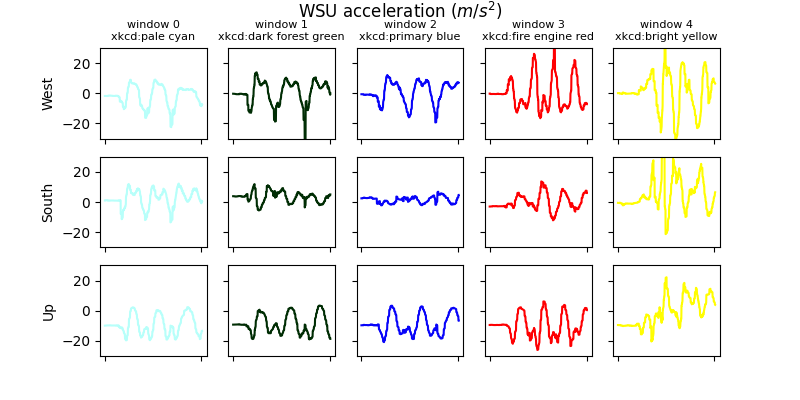

In [45]:

plot_accel_ref(navs_list, ncols=5)

In [23]:

# Get a sample of the the pison dataset.
# We choose the size big enough to see the scalability of the algorithms,
# but not too big to avoid too long running times
import math

N_SAMPLES = min(1500, pison_df.shape[0])
columns_list = [
    'channel_0_raw_in_ADC_counts',
    'channel_1_raw_in_ADC_counts',
    'channel_0_high_passed_in_ADC_counts',
    'channel_1_high_passed_in_ADC_counts',
    'quaternion_x',
    'quaternion_y',
    'quaternion_z',
    'quaternion_w',
    'gyroscope_x_in_degrees_per_second',
    'gyroscope_y_in_degrees_per_second',
    'gyroscope_z_in_degrees_per_second',
    'accelerometer_x_in_meters_per_second_squared',
    'accelerometer_y_in_meters_per_second_squared',
    'accelerometer_z_in_meters_per_second_squared']
def f(df):
    
    return df.sample(math.floor(N_SAMPLES / 15))
sample_df = pison_df.groupby('window_label').apply(f)
sample_df.window_label.value_counts()

0.0     100
1.0     100
2.0     100
3.0     100
4.0     100
5.0     100
6.0     100
7.0     100
8.0     100
9.0     100
10.0    100
11.0    100
12.0    100
13.0    100
14.0    100
Name: window_label, dtype: int64

In [50]:

def plot_window_nav(navs_list):
    fig = plt.figure(figsize=(9, 9))
    window_nums_list = [0, 1, 2, 3, 4, 8, 6, 7, 5, 9, 12, 11, 13, 14, 10]
    ncols = 5
    nrows = 15 // ncols
    i = 1
    for window_num in window_nums_list:
        ax = fig.add_subplot(nrows, ncols, i, projection='3d')
        i += 1
        color = COLORS_DICT[window_num]
        ax.scatter3D(navs_list[window_num][CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN], navs_list[window_num][QUATERNION_X_COLUMN],
                     navs_list[window_num][QUATERNION_Y_COLUMN], c=color, s=4)
        ax.set_title(f'Window {window_num} Position\n{color}', fontsize=8, fontweight='bold')
        ax.set_xlabel('W (m)', fontsize=6)
        ax.set_ylabel('S (m)', fontsize=6)
        ax.set_zlabel('U (m)', fontsize=6)


If there are only 5 wrist-motion classes (as inferred by the repetitions), how come the 3D plots don't look similar along columns?

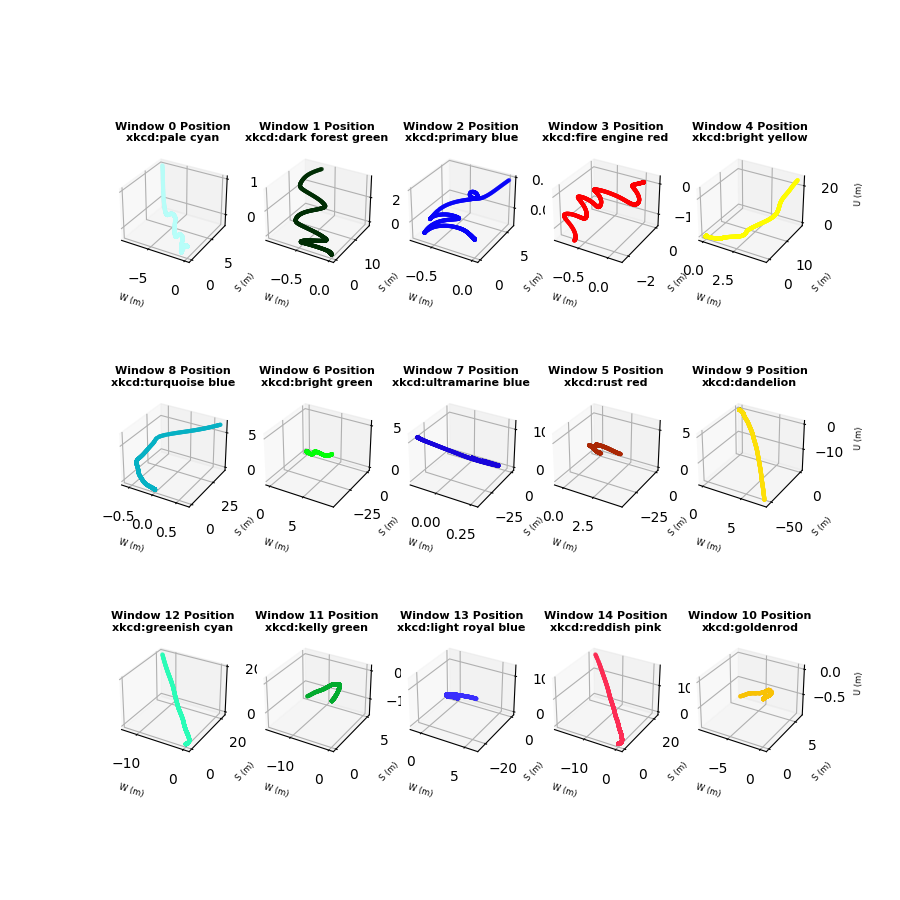

In [51]:

plot_window_nav(navs_list)


----
# Clustering Algorithms

In [26]:

from functools import partial
from sklearn import manifold
from collections import OrderedDict
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA

# We want to flatten the data into three
# dimensions to better visualize the space
n_components = 3

# Set-up manifold methods
n_neighbors = max(10, 1 + math.ceil(n_components * (n_components + 3) / 2))

LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver='auto',
)

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa', eigen_solver='dense')
methods['Hessian LLE'] = LLE(method='hessian', eigen_solver='dense')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['Spectral Embedding'] = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors
)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
methods['Incremental PCA'] = IncrementalPCA(n_components=n_components, batch_size=10)
methods['PCA'] = PCA(n_components=n_components)
methods['Kernel PCA'] = KernelPCA(kernel='rbf', fit_inverse_transform=True, gamma=10)
methods['Truncated SVD'] = TruncatedSVD(n_components=n_components)
methods['Factor Analysis'] = FactorAnalysis(n_components=n_components)
methods['Fast ICA'] = FastICA(n_components=n_components)

In [53]:

import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler

X1 = sample_df[columns_list].fillna(0).values
scaler = StandardScaler().fit(X1)
X1_scaled = scaler.transform(X1)

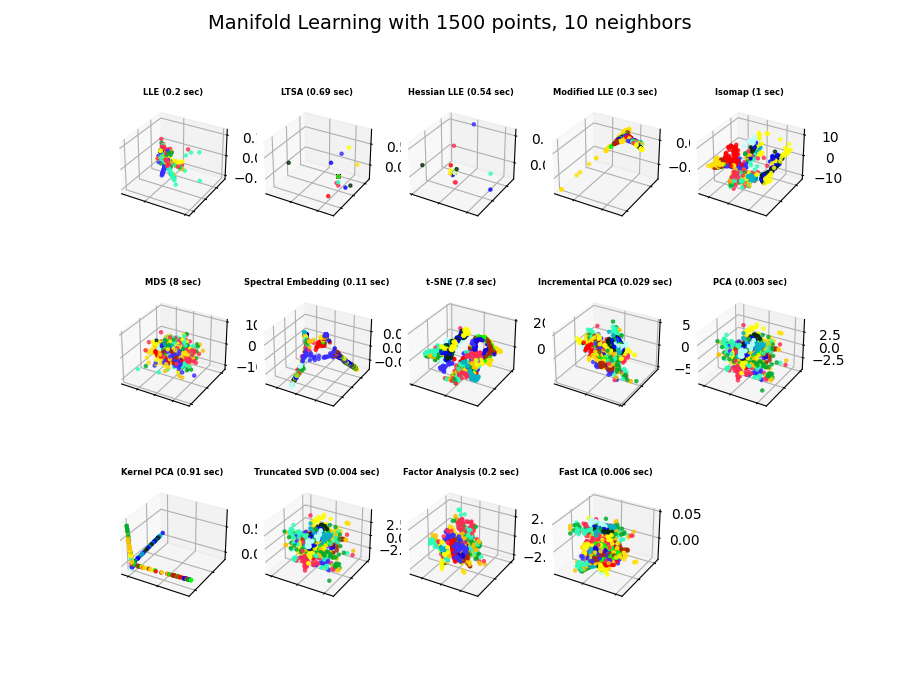

In [54]:

# Create figure
fig = plt.figure(figsize=(9, 7))
fig.suptitle(f'Manifold Learning with {N_SAMPLES} points, {n_neighbors} neighbors', fontsize=14)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    ax = fig.add_subplot(3, 5, 1 + i, projection='3d')
    t0 = time()
    try:
        y1 = method.fit_transform(X1_scaled)
        ax.set_title('%s (%.2g sec)' % (label, time() - t0), fontsize=6, fontweight='bold')
        ax.scatter3D(y1[:, 0], y1[:, 1], y1[:, 2], c=[COLORS_DICT[color] for color in sample_df.window_label], cmap=plt.cm.tab20, alpha=0.75, s=5)
    except (SystemError, RuntimeError, ValueError) as e:
        ax.set_title('%s (%.2g sec): %s' % (label, time() - t0, str(e).strip()[:10]))
        print(f'Error in {label}: {str(e).strip()}')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


----
### Let's try Labeling the Clusters from Factor Analysis

In [31]:

def get_colors_array(y_pred):
    colors_array = np.array(
        list(
            islice(
                cycle([
                    '#377eb8',
                    '#ff7f00',
                    '#4daf4a',
                    '#f781bf',
                    '#a65628',
                    '#984ea3',
                    '#999999',
                    '#e41a1c',
                    '#dede00',
                ]),
                int(max(y_pred) + 1),
            )
        )
    )
    
    # Add black color for outliers (if any)
    colors_array = np.append(colors_array, ['#000000'])
    
    return colors_array

In [32]:

def get_ypred(algorithm, X):
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            'ignore',
            message='the number of connected components of the '
            + 'connectivity matrix is [0-9]{1,2}'
            + ' > 1. Completing it to avoid stopping the tree early.',
            category=UserWarning,
        )
        warnings.filterwarnings(
            'ignore',
            message='Graph is not fully connected, tab20 embedding'
            + ' may not work as expected.',
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)
    
    return t0, t1, y_pred

In [57]:

def show_scatter_row(algorithms_dict, get_ypred):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    fig.suptitle(f'Cluster labelling with {N_SAMPLES} points', fontsize=14)
    fig.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )

    # Plot results
    for plot_num, (name, algorithm) in enumerate(algorithms_dict.items()):
        ax = fig.add_subplot(len(algorithms_dict) // 5, 5, 1 + plot_num, projection='3d')
        t0, t1, y_pred = get_ypred(algorithm, METHOD_X.copy(order='C')) #
        
        ax.set_title(F'{name} ({(t1-t0):0.2})', size=6)
        
        colors_array = get_colors_array(y_pred)
        ax.scatter3D(METHOD_X[:, 0], METHOD_X[:, 1], METHOD_X[:, 2], s=10, color=colors_array[y_pred])
        
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

In [55]:

METHOD_X = methods['Factor Analysis'].fit_transform(X1_scaled)

In [59]:

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
import time
import warnings
import numpy as np
from itertools import cycle, islice

params = {
    'quantile': 0.3,
    'eps': 0.3,
    'damping': 0.76,
    'preference': -200,
    'n_neighbors': 10,
    'n_clusters': 5, # Assumed number of wrist-motion classes
    'min_samples': 20,
    'xi': 0.05,
    'min_cluster_size': 0.1,
}

# Estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(METHOD_X, quantile=params['quantile'])

# Connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    METHOD_X, n_neighbors=params['n_neighbors'], include_self=False
)

# Make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity
)
tab20 = cluster.SpectralClustering(
    n_clusters=params['n_clusters'],
    eigen_solver='arpack',
    affinity='nearest_neighbors',
)
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(
    min_samples=params['min_samples'],
    xi=params['xi'],
    min_cluster_size=params['min_cluster_size'],
)
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'], random_state=0
)
average_linkage = cluster.AgglomerativeClustering(
    linkage='average',
    affinity='cityblock',
    n_clusters=params['n_clusters'],
    connectivity=connectivity,
)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full'
)

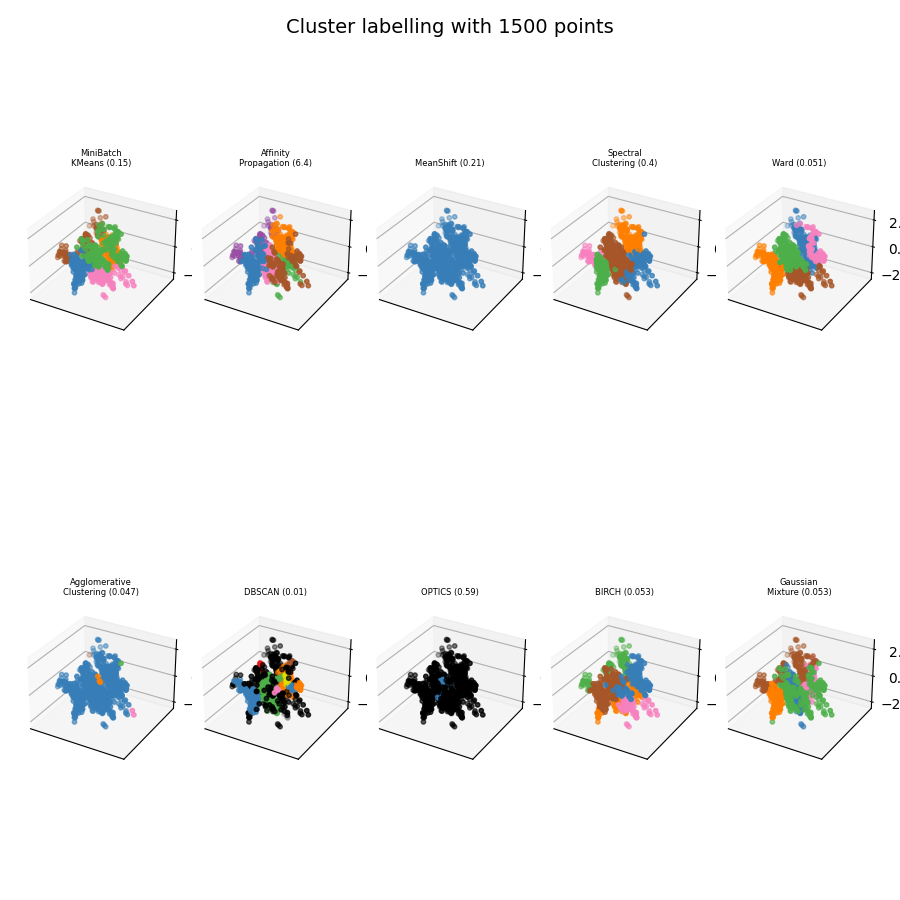

In [60]:

clustering_algorithms_dict = {
    'MiniBatch\nKMeans': two_means,
    'Affinity\nPropagation': affinity_propagation,
    'MeanShift': ms,
    'Spectral\nClustering': tab20,
    'Ward': ward,
    'Agglomerative\nClustering': average_linkage,
    'DBSCAN': dbscan,
    'OPTICS': optics,
    'BIRCH': birch,
    'Gaussian\nMixture': gmm
     }
show_scatter_row(clustering_algorithms_dict, get_ypred)

In [ ]:

t0, t1, y_pred = get_ypred(algorithm, METHOD_X)


----

In [39]:

def get_window_attitude_track(window_df):
    window_attitude_track = np.zeros((window_df.shape[0], 4))
    q_inv = np.array([
        -window_df.iloc[0].quaternion_x.squeeze(),
        -window_df.iloc[0].quaternion_y.squeeze(),
        -window_df.iloc[0].quaternion_z.squeeze(),
        window_df.iloc[0].quaternion_w.squeeze()
    ])
    for row_index, row_series in window_df.reset_index().iterrows():
        quaternion_x = row_series.quaternion_x
        quaternion_y = row_series.quaternion_y
        quaternion_z = row_series.quaternion_z
        quaternion_w = row_series.quaternion_w
        window_attitude_track[row_index, :] = quat_multiply(
            np.array([
                quaternion_x,
                quaternion_y,
                quaternion_z,
                quaternion_w
            ]),
            q_inv
        )
    
    return window_attitude_track

In [41]:

# Transform the time series orientations to be relative to the initial orientation of the given window
# rather than the reference WSU coordinate frame
attitude_tracks_list = [get_window_attitude_track(window_df) for window_df in WINDOW_DFS_LIST]

In [ ]:

def frame_trace(att_track):
    frames = []
    for i in range(len(att_track)):
        X = np.zeros((len(att_track[i]), CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN))
        Y = np.zeros((len(att_track[i]), CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN))
        Z = np.zeros((len(att_track[i]), CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN))
        X[TIMESTAMP_IN_MILLISECONDS_COLUMN, :] = np.array([
            CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN
        ])
        Y[TIMESTAMP_IN_MILLISECONDS_COLUMN, :] = np.array([
            TIMESTAMP_IN_MILLISECONDS_COLUMN,
            CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN
        ])    
        Z[TIMESTAMP_IN_MILLISECONDS_COLUMN, :] = np.array([
            TIMESTAMP_IN_MILLISECONDS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN,
            CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN,
            TIMESTAMP_IN_MILLISECONDS_COLUMN
        ])
        for ii in range(len(att_track[i])):
            q = att_track[i][ii, :]
            qinv = np.array([
                -att_track[i][ii, TIMESTAMP_IN_MILLISECONDS_COLUMN],
                -att_track[i][ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN],
                -att_track[i][ii, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN],
                att_track[i][ii, CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN]
            ])
            X[ii, :] = quat_multiply(quat_multiply(q, X[TIMESTAMP_IN_MILLISECONDS_COLUMN, :]), qinv)
            Y[ii, :] = quat_multiply(quat_multiply(q, Y[TIMESTAMP_IN_MILLISECONDS_COLUMN, :]), qinv)
            Z[ii, :] = quat_multiply(quat_multiply(q, Z[TIMESTAMP_IN_MILLISECONDS_COLUMN, :]), qinv)
        frames.append([X, Y, Z])
    return frames

In [ ]:

def ADCraw_dtw_matrix(windows):
    ADC_dtw = np.zeros((10, QUATERNION_X_COLUMN, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN))
    ADC_dtw_avg = np.zeros((10, QUATERNION_X_COLUMN))
    for i in range(QUATERNION_X_COLUMN, len(windows)):
        for ii in range(QUATERNION_X_COLUMN):
            ADC_dtw[i-5, ii, TIMESTAMP_IN_MILLISECONDS_COLUMN] = metrics.dtw(
                windows[ii][:, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN],
                windows[i][:, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
            )
            ADC_dtw[i-5, ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] = metrics.dtw(
                windows[ii][:, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN],
                windows[i][:, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]
            )
            ADC_dtw_avg[i-5, ii] = np.mean([
                ADC_dtw[i-5, ii, TIMESTAMP_IN_MILLISECONDS_COLUMN],
                ADC_dtw[i-5, ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
            ])
    return ADC_dtw_avg 

In [ ]:

def ADC_dtw_matrix(windows):
    ADC_dtw = np.zeros((10, QUATERNION_X_COLUMN, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN))
    ADC_dtw_avg = np.zeros((10, QUATERNION_X_COLUMN))
    for i in range(QUATERNION_X_COLUMN, len(windows)):
        for ii in range(QUATERNION_X_COLUMN):
            ADC_dtw[i-5, ii, TIMESTAMP_IN_MILLISECONDS_COLUMN] = metrics.dtw(
                signal.medfilt(windows[ii][:, CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN], 101),
                signal.medfilt(windows[i][:, CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN], 151)
            )
            ADC_dtw[i-5, ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] = metrics.dtw(
                signal.medfilt(windows[ii][:, CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN], 101),
                signal.medfilt(windows[i][:, CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN], 151)
            )
            ADC_dtw_avg[i-5, ii] = np.mean([
                ADC_dtw[i-5, ii, TIMESTAMP_IN_MILLISECONDS_COLUMN],
                ADC_dtw[i-5, ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]
            ])
    return ADC_dtw_avg    

In [ ]:

def trace_dtw_matrix(frame_trace):
    trace_dtw = np.zeros((10, QUATERNION_X_COLUMN, CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN))
    trace_dtw_avg = np.zeros((10, QUATERNION_X_COLUMN))
    for i in range(QUATERNION_X_COLUMN, len(frame_trace)):
        for ii in range(QUATERNION_X_COLUMN):
            for iii in range(CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN):
                trace_dtw[i-5, ii, iii] = metrics.dtw(frame_trace[ii][iii], frame_trace[i][iii])
            trace_dtw_avg[i-5, ii] = np.mean([
                trace_dtw[i-5, ii, TIMESTAMP_IN_MILLISECONDS_COLUMN],
                trace_dtw[i-5, ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN],
                trace_dtw[i-5, ii, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]
            ])
    return trace_dtw_avg

In [ ]:

def softmax_dtw_arrays(trace_dtw, ADC_dtw):
    x1 = np.zeros((10, QUATERNION_X_COLUMN))
    x2 = np.zeros((10, QUATERNION_X_COLUMN))
    for i in range(10):
        for ii in range(QUATERNION_X_COLUMN):
            x1[i, ii] = np.exp(-trace_dtw[i, ii]+min(trace_dtw[i, :]))/np.sum(np.exp(-trace_dtw[i, :]+min(trace_dtw[i, :])))
            x2[i, ii] = np.exp(-ADC_dtw[i, ii]+min(ADC_dtw[i, :]))/np.sum(np.exp(-ADC_dtw[i, :]+min(ADC_dtw[i, :])))
    softmax_labels = (x1+x2)/CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN
    return softmax_labels

In [ ]:

def max_prob(class_probs):
    candidates = []
    for i in range(QUATERNION_X_COLUMN):
        set1 = class_probs[TIMESTAMP_IN_MILLISECONDS_COLUMN:QUATERNION_X_COLUMN, i]
        set2 = class_probs[QUATERNION_X_COLUMN:10, i]
        temp = [set1.argmax()+QUATERNION_Y_COLUMN, set2.argmax()+11]
        candidates.append(temp)
    return candidates


""" Plotting functions"""

In [ ]:

def plot_body_rep(data):
    plt.figure()
    plt.plot(data[:, 15], label='Body Movement')
    plt.plot(data[:, 16], label='Repetition No.')
    plt.xlabel('sample')
    plt.legend()
    plt.title('Body Movement and Repetition no.')

In [ ]:

def plot_timestamps(data):
    plt.figure()
    plt.plot(
        data[:, TIMESTAMP_IN_MILLISECONDS_COLUMN]-data[TIMESTAMP_IN_MILLISECONDS_COLUMN, TIMESTAMP_IN_MILLISECONDS_COLUMN],
        label='Time elapsed (ms)'
    )
    plt.xlabel('sample')
    plt.legend()
    plt.title('Timestamps')   

In [ ]:

def ang_accum(windows):
    ang = []
    for i in range(len(windows)):
        XYZ = np.zeros((len(windows[i][:, 9]), CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN))
        tdiff = np.diff(windows[i][:, TIMESTAMP_IN_MILLISECONDS_COLUMN])/1000
        for ii in range(CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN, len(windows[i][:, 9])):
            XYZ[ii, TIMESTAMP_IN_MILLISECONDS_COLUMN] = XYZ[ii-1, TIMESTAMP_IN_MILLISECONDS_COLUMN]+tdiff[ii-1]*windows[i][ii-1, 9]
            XYZ[ii, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN] = XYZ[ii-1, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN]+tdiff[ii-1]*windows[i][ii-1, 10]
            XYZ[ii, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN] = XYZ[ii-1, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN]+tdiff[ii-1]*windows[i][ii-1, 11]
        ang.append(XYZ)
    return ang

In [ ]:

def plot_ang_accum(ang):
    for i in [CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN, 9, ACCELEROMETER_Z_IN_METERS_PER_SECOND_SQUARED_COLUMN]:
        plt.figure()
        ax1 = plt.subplot(311)
        plt.title('ENU accumulated angle window '+str(i+CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN))
        plt.plot(ang[i][CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN:, TIMESTAMP_IN_MILLISECONDS_COLUMN])
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.ylabel('East (deg)')
        matplotlib.axes.Axes.set_ylim(plt.gca(), bottom=-120, top=120)
    
        ax2 = plt.subplot(312, sharex=ax1)
        plt.plot(ang[i][CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN:, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN])
        plt.setp(ax2.get_xticklabels(), visible=False)
        matplotlib.axes.Axes.set_ylim(plt.gca(), bottom=-120, top=120)
        plt.ylabel('North (deg)')
        
        ax3 = plt.subplot(313, sharex=ax1)
        plt.plot(ang[i][CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN:, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN])
        plt.setp(ax3.get_xticklabels(), visible=False)
        matplotlib.axes.Axes.set_ylim(plt.gca(), bottom=-120, top=120)
        plt.ylabel('Up (deg)') 

In [ ]:

def plot_ex_ADC(windows):
    plt.figure()
    plt.plot(windows[TIMESTAMP_IN_MILLISECONDS_COLUMN][:, CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN])
    plt.title('CH0 Raw window CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN') 
    plt.ylabel('ADC count')
    plt.xlabel('sample')  
    plt.figure()
    plt.title('CH1 Raw window CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN')
    plt.plot(windows[TIMESTAMP_IN_MILLISECONDS_COLUMN][:, CHANNEL_1_RAW_IN_ADC_COUNTS_COLUMN])
    plt.ylabel('ADC count')
    plt.xlabel('sample')  
    plt.figure()
    plt.plot(windows[TIMESTAMP_IN_MILLISECONDS_COLUMN][:, CHANNEL_0_HIGH_PASSED_IN_ADC_COUNTS_COLUMN])
    plt.title('CH0 High passed window CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN')    
    plt.ylabel('ADC count')
    plt.xlabel('sample')  
    plt.figure()
    plt.title('CH1 High passed window CHANNEL_0_RAW_IN_ADC_COUNTS_COLUMN')
    plt.plot(windows[TIMESTAMP_IN_MILLISECONDS_COLUMN][:, CHANNEL_1_HIGH_PASSED_IN_ADC_COUNTS_COLUMN])
    plt.ylabel('ADC count')
    plt.xlabel('sample')  

In [ ]:

def plot_window8_medfilt(windows, col_index, kernel_size=151):
    """ Plots col_index in window QUATERNION_W_COLUMN w/ and without median filter"""
    plt.figure()
    plt.plot(
        windows[QUATERNION_W_COLUMN][:-1, 0]-windows[QUATERNION_W_COLUMN][0, 0],
        np.diff(windows[QUATERNION_W_COLUMN][:, col_index])
    )
    plt.title(col_name(col_index)+' original window QUATERNION_W_COLUMN')
    plt.xlabel('time (ms)')

    plt.figure()
    plt.plot(
        windows[QUATERNION_W_COLUMN][:-1, 0]-windows[QUATERNION_W_COLUMN][0, 0],
        signal.medfilt(np.diff(windows[QUATERNION_W_COLUMN][:, col_index]), kernel_size)
    )
    plt.title(col_name(col_index)+' med filter window QUATERNION_W_COLUMN')
    plt.xlabel('time (ms)')